In [1]:
!pip install neuralforecast

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/pycups-2.0.1-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/PyPDF3-0.0.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 2.3 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 MB 17.0 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.6 MB

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Импорт данных

In [79]:
df = pd.read_csv('./данные для исследований/Индикатор бизнес-климата ЦБ (промышленность), пункты, Россия — Диаграмма.csv', sep=';')

Для библиотеки необходимо определнно назвать столбцы

In [80]:
# Меняем названия столбцов
df.columns = ['unique_id', 'ds', 'y']

# Меняем формат даты
df.ds = pd.to_datetime(df.ds, format='%d.%m.%Y')

# Добавляем скользящее среднее
window = 24
df_with_trend = df.iloc[window - 1:]
df_with_trend['trend'] = np.convolve(df.y, np.ones(window)/window, 'valid')

df_with_trend.head(3)

/tmp/ipykernel_4533/1817208288.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_trend['trend'] = np.convolve(df.y, np.ones(window)/window, 'valid')


,unique_id,ds,y,trend
23,62291,2003-12-31,9.633232,10.156588
24,62291,2004-01-31,5.871889,10.402589
25,62291,2004-02-29,13.235736,10.755941


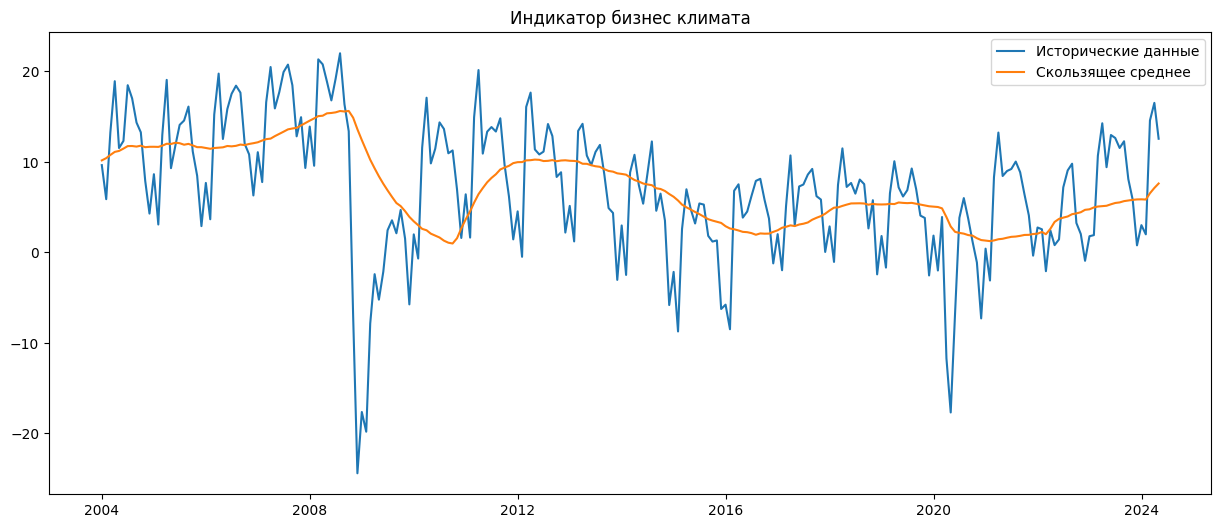

In [81]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.set_title('Индикатор бизнес климата')

ax.plot(df_with_trend.ds, df_with_trend.y, label='Исторические данные')
ax.plot(df_with_trend.ds, df_with_trend.trend, label='Скользящее среднее')

ax.legend()

# Нейросетевые прогнозы

In [84]:
from neuralforecast import NeuralForecast
from neuralforecast.models import GRU, NHITS, TFT
from neuralforecast.losses.pytorch import MSE

In [169]:
horizon = 3     # прогноз на 3 месяца
lookback = 12   # длина входных данных
maxsteps = 100
learning_rate = 0.001

In [170]:
df_train = df.iloc[:-48]   # 268 Значений
df_test = df.iloc[-48:]    # 48 значений

In [171]:
models = [
    # Рекурентная нейросеть
    GRU(                     
        h=horizon,
        input_size=lookback,
        scaler_type='standard',
        max_steps=maxsteps,
        encoder_hidden_size=2, # Defines the size of the hidden state of the GRU
        decoder_hidden_size=2, # Defines the number of hidden units of each layer of the MLP decoder
        loss=MSE(),
        learning_rate=learning_rate
    ),
    # 
    NHITS(
        h=horizon,
        input_size=lookback,
        max_steps=maxsteps,
        scaler_type='standard',
        loss=MSE(),
        learning_rate=learning_rate
    ),
    # Трансформер
    VanillaTransformer(
        h=horizon,
        input_size=lookback,
        hidden_size=8,
        conv_hidden_size=16,
        n_head=2,
        loss=MSE(),
        scaler_type='robust',
        learning_rate=0.001,
        max_steps=500,
        val_check_steps=50,
        early_stop_patience_steps=2
    )
]

nf = NeuralForecast(models=models, freq='M')
nf.fit(df=df_train, val_size=12)

Seed set to 1
Seed set to 1
Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params
--------------------------------------------------
0 | loss            | MSE           | 0     
1 | padder          | ConstantPad1d | 0     
2 | scaler          | TemporalNorm  | 0     
3 | hist_encoder    | GRU           | 66    
4 | context_adapter | Linear        | 90    
5 | mlp_decoder     | MLP           | 25    
--------------------------------------------------
181       Trainable params
0         Non-trainable params
181       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MSE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.595     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MSE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | enc_embedding | DataEmbedding | 24    
4 | dec_embedding | DataEmbedding | 24    
5 | encoder       | TransEncoder  | 1.2 K 
6 | decoder       | TransDecoder  | 929   
------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

In [173]:
predicts = nf.predict(df.iloc[:-horizon]).reset_index()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

/home/misha/.local/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [174]:
predicts

,unique_id,ds,GRU,NHITS,VanillaTransformer
0,62291,2024-02-29,6.390918,8.966118,8.424517
1,62291,2024-03-31,6.327539,10.900393,12.445900
2,62291,2024-04-30,5.520412,7.649800,12.547323


In [175]:
from datetime import datetime

filtered_df = df[df.ds > datetime(year=2015, month=1, day=1)]

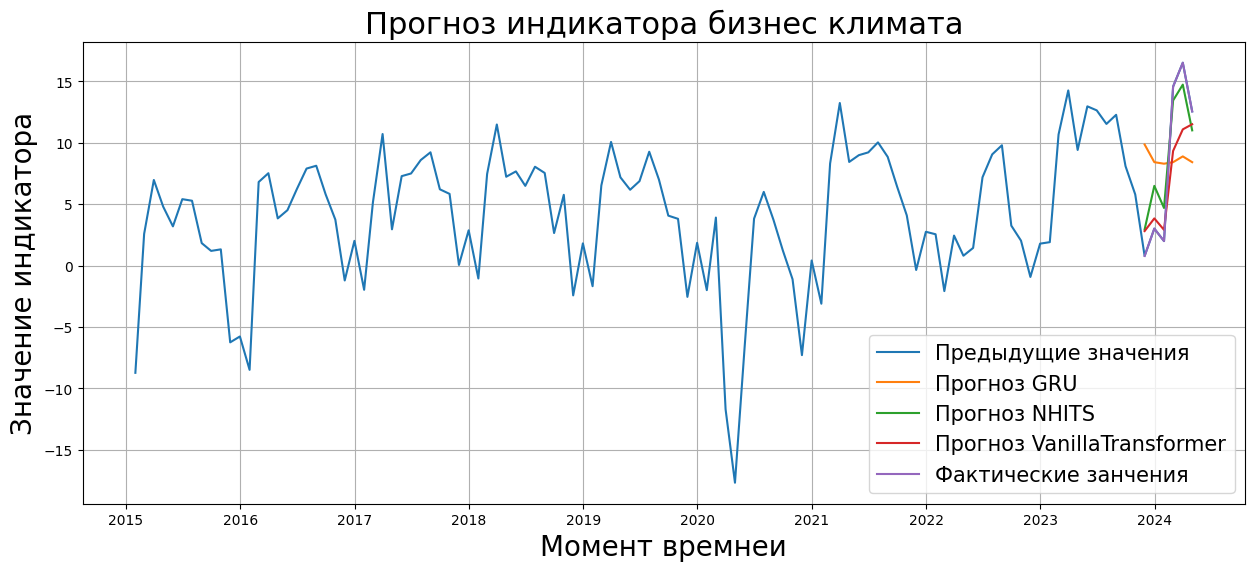

In [168]:
fig, ax = plt.subplots(figsize = (15, 6))

plt.plot(filtered_df.ds, filtered_df.y, label='Предыдущие значения')
plt.plot(predicts.ds, predicts.GRU, label='Прогноз GRU')
plt.plot(predicts.ds, predicts.NHITS, label='Прогноз NHITS')
plt.plot(predicts.ds, predicts.VanillaTransformer, label='Прогноз VanillaTransformer')
plt.plot(df.ds.iloc[-horizon:], df.y.iloc[-6:], label='Фактические занчения')

ax.set_title('Прогноз индикатора бизнес климата', fontsize=22)
ax.set_ylabel('Значение индикатора', fontsize=20)
ax.set_xlabel('Момент времнеи', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()
